Basic imports


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.python.keras as keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
import gc, warnings, json


Load in the main dataset


In [2]:
with open("./input/steamspy/detailed/steam_spy_detailed.json", "r") as f:
    raw_file = json.load(f)


# Return format for an app:

- appid - Steam Application ID. If it's 999999, then data for this application is hidden on developer's request, sorry.
- name - game's name
- ~~developer - comma separated list of the developers of the game~~
- ~~publisher - comma separated list of the publishers of the game~~
- ~~score_rank - score rank of the game based on user reviews~~
- ~~owners - owners of this application on Steam as a range.~~
- average_forever - average playtime since March 2009. In minutes.
- ~~average_2weeks - average playtime in the last two weeks. In minutes.~~
- median_forever - median playtime since March 2009. In minutes.
- ~~median_2weeks - median playtime in the last two weeks. In minutes.~~
- ~~ccu - peak CCU yesterday.~~
- ~~price - current US price in cents.~~
- initialprice - original US price in cents.
- ~~discount - current discount in percents.~~
- ~~tags - game's tags with votes in JSON array.~~
- languages - list of supported languages.
- genre - list of genres.

Strikethrough indicates dropped variable not used in our analysis


In [3]:
spy_data = pd.DataFrame.from_records(raw_file).T
del raw_file
gc.collect()
spy_data.drop(
    [
        "appid",
        "developer",
        "publisher",
        "score_rank",
        "userscore",
        "owners",
        "average_2weeks",
        "median_2weeks",
        "price",
        "discount",
        "ccu",
        "tags",
    ],
    axis=1,
    inplace=True,
)
spy_data.rename(
    {
        "name": "Name",
        "positive": "Positive Reviews",
        "negative": "Negative Reviews",
        "average_forever": "Average Playtime",
        "median_forever": "Median Playtime",
        "initialprice": "Price",
        "languages": "Languages",
        "genre": "Genres",
    },
    axis=1,
    inplace=True,
)


In [4]:
spy_data.head()


,Name,Positive Reviews,Negative Reviews,Average Playtime,Median Playtime,Price,Languages,Genres
10,Counter-Strike,196594,5073,10978,311,999,"English, French, German, Italian, Spanish - Sp...",Action
100,Counter-Strike: Condition Zero,13442,1535,813,57,999,"English, French, German, Italian, Spanish - Sp...",Action
1000000,ASCENXION,27,5,0,0,999,"English, Korean, Simplified Chinese","Action, Adventure, Indie"
1000010,Crown Trick,3812,584,775,1033,1999,"English, Simplified Chinese, Japanese, Traditi...","Adventure, Indie, RPG, Strategy"
1000030,"Cook, Serve, Delicious! 3?!",1470,102,83,107,1999,English,"Action, Indie, Simulation, Strategy"


Read in player count data

NOTE: This takes a great deal of RAM, will not run with less than 16 gb


In [5]:
with open("./input/steam_charts/steam_charts.json", "r") as f:
    raw_player_count_file = json.load(f)


To save space, we just take the mean of each game over time, rather than making a dataset with all information then averaging from there.


In [6]:
mean_dict = {}
for key in raw_player_count_file.keys():
    mean_dict[key] = (
        pd.DataFrame(raw_player_count_file[key], index=[key]).mean(axis=1).iloc[0]
    )
player_count_data = pd.DataFrame(
    mean_dict, index=["Mean Concurrent Players All Time"]
).T.sort_index()


In [7]:
player_count_data.head()


,Mean Concurrent Players All Time
10,11408.154961
100,49.588629
1000000,0.382979
1000010,69.729662
1000030,46.014870


Merge both datasets to make analysis easier


In [8]:
all_data = spy_data.merge(
    player_count_data, how="inner", left_index=True, right_index=True
)
all_data.head()


,Name,Positive Reviews,Negative Reviews,Average Playtime,Median Playtime,Price,Languages,Genres,Mean Concurrent Players All Time
10,Counter-Strike,196594,5073,10978,311,999,"English, French, German, Italian, Spanish - Sp...",Action,11408.154961
100,Counter-Strike: Condition Zero,13442,1535,813,57,999,"English, French, German, Italian, Spanish - Sp...",Action,49.588629
1000000,ASCENXION,27,5,0,0,999,"English, Korean, Simplified Chinese","Action, Adventure, Indie",0.382979
1000010,Crown Trick,3812,584,775,1033,1999,"English, Simplified Chinese, Japanese, Traditi...","Adventure, Indie, RPG, Strategy",69.729662
1000030,"Cook, Serve, Delicious! 3?!",1470,102,83,107,1999,English,"Action, Indie, Simulation, Strategy",46.014870


Turn the `Languages` and `Generes` columns into lists to make encoding easier. We also drop any NA values to help analysis.


In [9]:
all_data["Languages"] = all_data["Languages"].str.split(", ")
all_data["Genres"] = all_data["Genres"].str.split(", ")
all_data = all_data.loc[all_data["Languages"].notna()]
all_data = all_data.loc[all_data["Mean Concurrent Players All Time"].notna()]


Now we encode most columns using `OrdinalEncoder` and the list columns using `MultiLabelBinarizer` to let scikit learn and keras models work nicely with our data.


In [10]:
mlb = MultiLabelBinarizer()
oe = OrdinalEncoder(dtype="uint32")
column_transform = make_column_transformer(
    (
        oe,
        [
            "Positive Reviews",
            "Negative Reviews",
            "Average Playtime",
            "Median Playtime",
            "Price",
        ],
    )
)
X = column_transform.fit_transform(all_data)
X_languages = mlb.fit_transform(all_data["Languages"].tolist())
X_genres = mlb.fit_transform(all_data["Genres"].tolist())
Xtmp = [[] for _ in range(len(X))]
Xt = [[] for _ in range(len(X))]
for i in range(len(X)):
    Xtmp[i] = np.append(X[i], X_languages[i])
    Xt[i] = np.append(Xtmp[i], X_genres[i])
Xt = np.stack(Xt, axis=0)


Our target is the mean player count, so we'll save that as `y`


In [11]:
y = np.array(all_data["Mean Concurrent Players All Time"])


Basic 50-50 split of data into test and train groups


In [12]:
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.50, shuffle=True)
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


((25919, 83), (25919,), (25920, 83), (25920,))

Now we try some scikit-learn regression models, first up is Lasso.


In [13]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)


0.03218058018317693

That score is abysmal (for reference, a perfect score is 1 and anything under 0 is arbitrarily worse than a constant model). Let's try an ElasticNet now.


In [14]:
enet = ElasticNet()
enet.fit(X_train, y_train)
enet.score(X_test, y_test)


0.03540046498383753

Still very poor performance, but at least it's positive now. Let's try a classic Ridge model.


In [15]:
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)


0.0320521511338816

Back to negative scores, that does not inspire confidence in these features. Just to make sure, we'll try a couple more models.


In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)


0.031959163844903715

As expected, still awful performance. The last three models to try are Support Vector Regression models, each using a slightly different formula.


In [17]:
svr = SVR()
svr.fit(X_train, y_train)
svr.score(X_test, y_test)


0.0016541584971957457

In [18]:
nsvr = NuSVR()
nsvr.fit(X_train, y_train)
nsvr.score(X_test, y_test)


0.0016669089837870743

In [19]:
lsvr = LinearSVR(max_iter=1e3)
lsvr.fit(X_train, y_train)
lsvr.score(X_test, y_test)


c:\Users\spwun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.013855258968183959

Not great from anything there, but at least the SVRs are giving positive numbers, so they're ever so slightly better than a constant model.


Neural network time! We'll use a basic dense net to try to see if we can find any mapping of these features that will give us an accurate prediction.


In [20]:
class EvaluateCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        if "test loss" not in logs:
            logs["test loss"] = []
            logs["test acc"] = []
        logs["test loss"] += [loss]
        logs["test acc"] += [acc]
        print(f"Testing loss: {loss:6.4f}, Testing accuracy: {acc:6.4f}")


Our first model is a basic linear net with a single softmax activation layer piped to a single output. We'll use mean squared logarithmic error as our loss function to prevent losses from being massive. 10 samples per batch and 100 epochs should be enough to reach a weak convergence.


In [21]:
warnings.filterwarnings("ignore")
tf.get_logger().setLevel("WARNING")
linear_model = keras.Sequential()
linear_model.add(keras.layers.Dense(83, activation="softmax"))
linear_model.add(keras.layers.Dense(1, kernel_initializer="normal"))

linear_model.compile(
    loss="mean_squared_logarithmic_error", optimizer="adam", metrics=["accuracy"]
)
linear_history = linear_model.fit(
    X_train,
    y_train,
    batch_size=10,
    epochs=100,
    verbose=1,
    callbacks=[EvaluateCallback((X_test, y_test))],
)
linear_model.summary()


Epoch 1/100
2592/2592 [==============================] - 1s 480us/step - loss: 1.8174 - accuracy: 0.0563
Testing loss: 1.3743, Testing accuracy: 0.0564
Epoch 2/100
2592/2592 [==============================] - 1s 499us/step - loss: 1.2586 - accuracy: 0.0557
Testing loss: 1.1179, Testing accuracy: 0.0564
Epoch 3/100
2592/2592 [==============================] - 1s 486us/step - loss: 1.0858 - accuracy: 0.0555
Testing loss: 0.9944, Testing accuracy: 0.0566
Epoch 4/100
2592/2592 [==============================] - 1s 496us/step - loss: 0.9857 - accuracy: 0.0558
Testing loss: 0.9186, Testing accuracy: 0.0566
Epoch 5/100
2592/2592 [==============================] - 1s 491us/step - loss: 0.9184 - accuracy: 0.0559
Testing loss: 0.8595, Testing accuracy: 0.0572
Epoch 6/100
2592/2592 [==============================] - 1s 489us/step - loss: 0.8775 - accuracy: 0.0563
Testing loss: 0.8471, Testing accuracy: 0.0573
Epoch 7/100
2592/2592 [==============================] - 1s 492us/step - loss: 0.8483 - 

Slightly better than our basic ML models, but still very poor. 5% accuracy is nowhere near good enough to say there is any sort of association between our features and our target. Let's look at the graph of accuracy over epochs to see if we're converging at all.


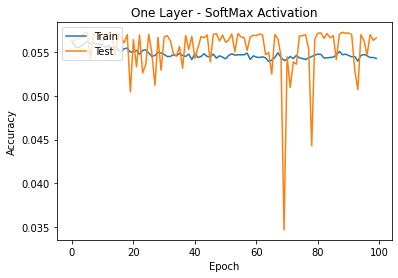

In [22]:
fig, ax = plt.subplots()
ax.plot(linear_history.history["accuracy"], label="Train")
ax.plot(linear_history.history["test acc"], label="Test")
ax.set_title("One Layer - SoftMax Activation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc="upper left")


Rather than converging to a better score, it looks like our model gets worse as time goes on, meaning it's probably overfitting to the wrong features, explaining the exceptionally poor prediction rate.


Now we'll try adding a ReLu layer to disable any neurons that make our model worse.


In [23]:
one_layer = keras.Sequential(name="one_layer")
one_layer.add(keras.layers.Dense(83, activation="softmax"))
one_layer.add(keras.layers.Dense(83, activation="relu"))
one_layer.add(keras.layers.Dense(1, kernel_initializer="normal"))

one_layer.compile(
    loss="mean_squared_logarithmic_error", optimizer="adam", metrics=["accuracy"]
)
one_layer_history = one_layer.fit(
    X_train,
    y_train,
    batch_size=100,
    epochs=100,
    verbose=1,
    callbacks=[EvaluateCallback((X_test, y_test))],
)
one_layer.summary()


Epoch 1/100
260/260 [==============================] - 0s 694us/step - loss: 1.7563 - accuracy: 0.0552
Testing loss: 1.0140, Testing accuracy: 0.0574
Epoch 2/100
260/260 [==============================] - 0s 687us/step - loss: 0.9023 - accuracy: 0.0563
Testing loss: 0.8107, Testing accuracy: 0.0567
Epoch 3/100
260/260 [==============================] - 0s 703us/step - loss: 0.7674 - accuracy: 0.0562
Testing loss: 0.7042, Testing accuracy: 0.0573
Epoch 4/100
260/260 [==============================] - 0s 693us/step - loss: 0.6953 - accuracy: 0.0564
Testing loss: 0.6495, Testing accuracy: 0.0568
Epoch 5/100
260/260 [==============================] - 0s 707us/step - loss: 0.6630 - accuracy: 0.0563
Testing loss: 0.6591, Testing accuracy: 0.0573
Epoch 6/100
260/260 [==============================] - 0s 701us/step - loss: 0.6289 - accuracy: 0.0564
Testing loss: 0.5986, Testing accuracy: 0.0572
Epoch 7/100
260/260 [==============================] - 0s 708us/step - loss: 0.6016 - accuracy: 0.05

Not much change from this layer, but it is interesting to see there was no major loss of accuracy, probably thanks to ReLu's protection from negative weights.


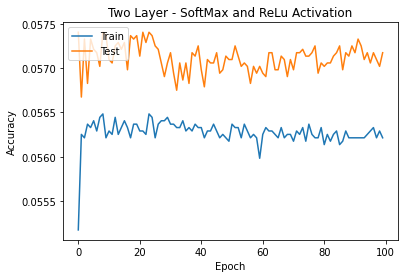

In [44]:
fig, ax = plt.subplots()
ax.plot(one_layer_history.history["accuracy"], label="Train")
ax.plot(one_layer_history.history["test acc"], label="Test")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Two Layer - SoftMax and ReLu Activation")
ax.legend(loc="upper left")


The graph tells a similar story, any neurons that tried to lower the accuracy were turned off by ReLu and the accuracy was only able to grow until the important neurons were found and the model stabilized.


Lastly we'll swap both layers to a tanh activation instead of a softmax or ReLu function, as tanh gives values in the range of [-1, 1] so we should still be able to get some information from the neurons that ReLu turned off entirely.


In [25]:
two_layer = keras.Sequential(name="two_layer")
two_layer.add(keras.layers.Dense(83, activation="tanh"))
two_layer.add(keras.layers.Dense(83, activation="tanh"))
two_layer.add(keras.layers.Dense(1, kernel_initializer="normal"))

two_layer.compile(
    loss="mean_squared_logarithmic_error", optimizer="adam", metrics=["accuracy"]
)
two_layer_history = two_layer.fit(
    X_train,
    y_train,
    batch_size=100,
    epochs=100,
    verbose=1,
    callbacks=[EvaluateCallback((X_test, y_test))],
)
two_layer.summary()


Epoch 1/100
260/260 [==============================] - 0s 629us/step - loss: 1.1808 - accuracy: 0.0558
Testing loss: 0.9069, Testing accuracy: 0.0555
Epoch 2/100
260/260 [==============================] - 0s 631us/step - loss: 0.8663 - accuracy: 0.0565
Testing loss: 0.7971, Testing accuracy: 0.0568
Epoch 3/100
260/260 [==============================] - 0s 633us/step - loss: 0.7889 - accuracy: 0.0564
Testing loss: 0.7498, Testing accuracy: 0.0567
Epoch 4/100
260/260 [==============================] - 0s 627us/step - loss: 0.7415 - accuracy: 0.0564
Testing loss: 0.7019, Testing accuracy: 0.0569
Epoch 5/100
260/260 [==============================] - 0s 631us/step - loss: 0.7039 - accuracy: 0.0563
Testing loss: 0.6734, Testing accuracy: 0.0572
Epoch 6/100
260/260 [==============================] - 0s 646us/step - loss: 0.6792 - accuracy: 0.0564
Testing loss: 0.6467, Testing accuracy: 0.0573
Epoch 7/100
260/260 [==============================] - 0s 633us/step - loss: 0.6539 - accuracy: 0.05

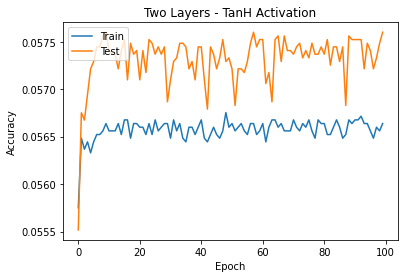

In [42]:
fig, ax = plt.subplots()
ax.plot(two_layer_history.history["accuracy"], label="Train")
ax.plot(two_layer_history.history["test acc"], label="Test")
ax.set_title("Two Layers - TanH Activation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc="upper left")


Once again, there is no noticeable increase in accuracy, though this does seem to follow the same pattern as our last two layer model. Most likely we've found the max accuracy our model can fit with these features. At just over 5%, it's obvious that these features are not enough to predict our target well. This makes sense, as a game's features are not often a good indicator of whether the game will perform well or not. Usually a game's popularity is determined by more than a simple mix of basic information. If it were to be that easy, game developers would have figured it out many years ago and exploited it to ensure they made the most sales possible.


Last thing to try is fitting a couple neural nets on single variables rather than the whole dataset, just to get an idea of what has the most influence.


In [27]:
Xl_train, Xl_test, y_train, y_test = train_test_split(
    X_languages, y, test_size=0.5, shuffle=True
)
(Xl_train.shape, y_train.shape, Xl_test.shape, y_test.shape)

((25919, 44), (25919,), (25920, 44), (25920,))

In [30]:
language_one_layer = keras.Sequential(name="one_layer")
language_one_layer.add(keras.layers.Dense(44, activation="softmax"))
language_one_layer.add(keras.layers.Dense(44, activation="relu"))
language_one_layer.add(keras.layers.Dense(1, kernel_initializer="normal"))

language_one_layer.compile(
    loss="mean_squared_logarithmic_error", optimizer="adam", metrics=["accuracy"]
)
language_one_layer_history = language_one_layer.fit(
    Xl_train,
    y_train,
    batch_size=100,
    epochs=100,
    verbose=1,
    callbacks=[EvaluateCallback((Xl_test, y_test))],
)
language_one_layer.summary()


Epoch 1/100
260/260 [==============================] - 0s 583us/step - loss: 2.2962 - accuracy: 0.0179
Testing loss: 1.9746, Testing accuracy: 0.0009
Epoch 2/100
260/260 [==============================] - 0s 566us/step - loss: 1.8463 - accuracy: 0.0014
Testing loss: 1.8259, Testing accuracy: 0.0009
Epoch 3/100
260/260 [==============================] - 0s 562us/step - loss: 1.7648 - accuracy: 0.0014
Testing loss: 1.7669, Testing accuracy: 0.0009
Epoch 4/100
260/260 [==============================] - 0s 556us/step - loss: 1.7362 - accuracy: 0.0014
Testing loss: 1.7452, Testing accuracy: 0.0009
Epoch 5/100
260/260 [==============================] - 0s 558us/step - loss: 1.7185 - accuracy: 0.0014
Testing loss: 1.7273, Testing accuracy: 0.0010
Epoch 6/100
260/260 [==============================] - 0s 552us/step - loss: 1.7025 - accuracy: 0.0015
Testing loss: 1.7134, Testing accuracy: 0.0009
Epoch 7/100
260/260 [==============================] - 0s 561us/step - loss: 1.6887 - accuracy: 0.00

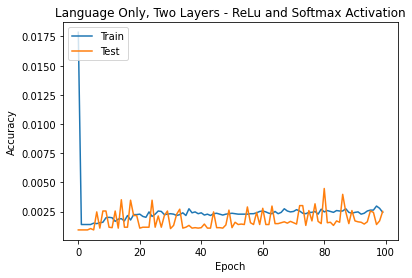

In [38]:
fig, ax = plt.subplots()
ax.plot(language_one_layer_history.history["accuracy"], label="Train")
ax.plot(language_one_layer_history.history["test acc"], label="Test")
ax.set_title("Language Only, Two Layers - ReLu and Softmax Activation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc="upper left")


In [39]:
Xg_train, Xg_test, y_train, y_test = train_test_split(
    X_languages, y, test_size=0.5, shuffle=True
)
(Xg_train.shape, y_train.shape, Xg_test.shape, y_test.shape)

((25919, 44), (25919,), (25920, 44), (25920,))

In [40]:
genre_one_layer = keras.Sequential(name="one_layer")
genre_one_layer.add(keras.layers.Dense(83, activation="softmax"))
genre_one_layer.add(keras.layers.Dense(83, activation="relu"))
genre_one_layer.add(keras.layers.Dense(1, kernel_initializer="normal"))

genre_one_layer.compile(
    loss="mean_squared_logarithmic_error", optimizer="adam", metrics=["accuracy"]
)
genre_one_layer_history = genre_one_layer.fit(
    Xg_train,
    y_train,
    batch_size=100,
    epochs=100,
    verbose=1,
    callbacks=[EvaluateCallback((Xg_test, y_test))],
)
genre_one_layer.summary()

Epoch 1/100
260/260 [==============================] - 0s 647us/step - loss: 2.2738 - accuracy: 0.0133
Testing loss: 1.8961, Testing accuracy: 0.0014
Epoch 2/100
260/260 [==============================] - 0s 636us/step - loss: 1.8616 - accuracy: 9.6454e-04
Testing loss: 1.7517, Testing accuracy: 0.0014
Epoch 3/100
260/260 [==============================] - 0s 637us/step - loss: 1.7835 - accuracy: 0.0010
Testing loss: 1.7215, Testing accuracy: 0.0014
Epoch 4/100
260/260 [==============================] - 0s 644us/step - loss: 1.7585 - accuracy: 0.0014
Testing loss: 1.7079, Testing accuracy: 0.0014
Epoch 5/100
260/260 [==============================] - 0s 637us/step - loss: 1.7397 - accuracy: 0.0014
Testing loss: 1.6838, Testing accuracy: 0.0014
Epoch 6/100
260/260 [==============================] - 0s 633us/step - loss: 1.7164 - accuracy: 0.0014
Testing loss: 1.6693, Testing accuracy: 0.0015
Epoch 7/100
260/260 [==============================] - 0s 631us/step - loss: 1.7047 - accuracy: 

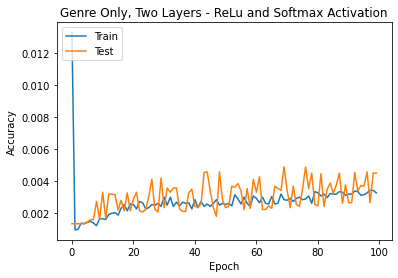

In [41]:
fig, ax = plt.subplots()
ax.plot(genre_one_layer_history.history["accuracy"], label="Train")
ax.plot(genre_one_layer_history.history["test acc"], label="Test")
ax.set_title("Genre Only, Two Layers - ReLu and Softmax Activation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc="upper left")